In [8]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

from tsp import TSP
from solvers import AntSystemSolver, AntColonySystemSolver
from visualization import *

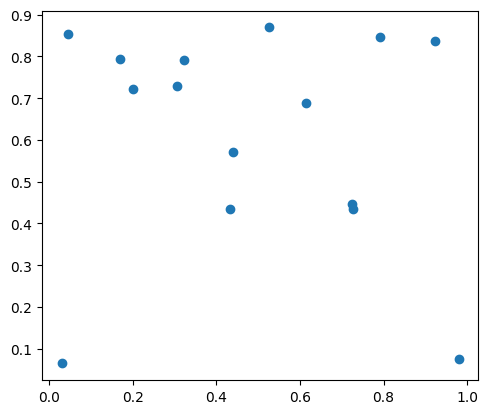

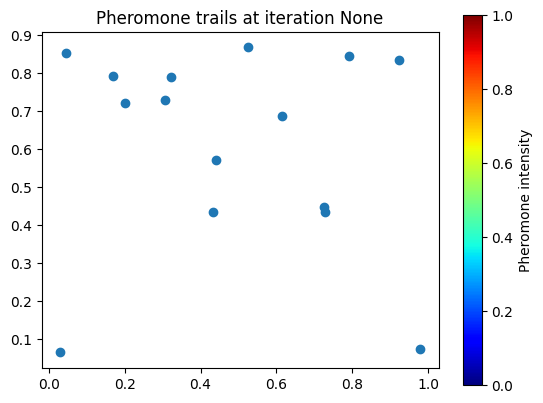

In [9]:
# debugging

# square
# cities = np.array([[2, 1], [2, 2], [1, 1], [1, 2]])
# tsp = TSP.from_instance(cities)

# circle
# cities = np.array([[0, 1], [0.25, 0.5], [0.3232, 0.3232], [0.5, 0.25], [0.6768, 0.3232], [0.75, 0.5], [1, 1]])
# tsp = TSP.from_instance(cities)

# random
tsp = TSP.random_instance(15)

solver = AntColonySystemSolver(tsp)

plot_solution(tsp.cities, save_dir=None)
plot_pheromone_trails(tsp.cities, solver.pheromones, save_dir=None)

In [10]:
NUM_IT = 1000
least_cost = np.inf
avg_costs = {
    'train': [],
    'val': []
}
for it in range(NUM_IT):
    # sampling a batch of solutions for training
    train_tours = solver.sample(local_update_strategy='ACS')
    train_costs = tsp.evaluate(train_tours)
    avg_costs['train'].append(np.mean(train_costs))

    # getting a batch of solutions using greedy strategy for validation
    val_tours = solver.sample(strategy='greedy', apply_local_pheromone_update=False)
    val_costs = tsp.evaluate(val_tours)
    avg_costs['val'].append(np.mean(val_costs))

    # selecting the best tour from validation
    best_tour = val_tours[np.argmin(val_costs)]
    min_val_cost = np.min(val_costs)
    if min_val_cost < least_cost:
        least_cost = min_val_cost
        print(f'--> Best tour so far: {best_tour}, cost: {least_cost}, it: {it},')
    
    # plotting
    if it % 25 == 0:
        plot_solution(tsp.cities, val_tours[np.argmin(val_costs)], np.min(val_costs), save_dir=f'results/tours/tour_{it}')
        plot_pheromone_trails(tsp.cities, solver.pheromones, iteration=it, save_dir=f'results/pheromones/trails_{str(it).zfill(4)}')
    
    # updating the pheromone matrix
    solver.update_pheromone(train_tours)

plot_mean_cost(avg_costs['val'], save_dir=f'results/costs/costs_{it}')
plt.close()

--> Best tour so far: [14 11  0  8  9  6  2  5 10 12 13  4  1  7  3], cost: 4.79066067133218, it: 0,
--> Best tour so far: [ 9 11 14  8  0 10  2  6 12  5  4  7  3 13  1], cost: 4.733839337773277, it: 2,
--> Best tour so far: [ 9 11 14  8  0  2 10  5  6 12  7  4 13  1  3], cost: 4.698066191477464, it: 6,
--> Best tour so far: [12  4  5 10 13  7  2  6 14  8  0 11  9  1  3], cost: 4.639764118559198, it: 7,
--> Best tour so far: [11 14  9  8  0 10  2  6  3  5 12  4  7  1 13], cost: 4.440690794201843, it: 11,
--> Best tour so far: [ 9 11 14  8  0 10  2  6  5  7 12  4 13  1  3], cost: 4.102550091431925, it: 17,
--> Best tour so far: [12  4  5 10  7 13  6  2  0  8 14  9 11  3  1], cost: 4.042985160116167, it: 22,
--> Best tour so far: [ 9 11 14  0  8  2 10  6  5 12  4 13  7  1  3], cost: 3.910897546061532, it: 52,
--> Best tour so far: [ 9 11 14  8  0  2 10  6  5 12  4 13  7  1  3], cost: 3.901203009873003, it: 53,
--> Best tour so far: [ 9 11 14  0  8 10  2  6  3  5 12  4  7 13  1], cost: 3.

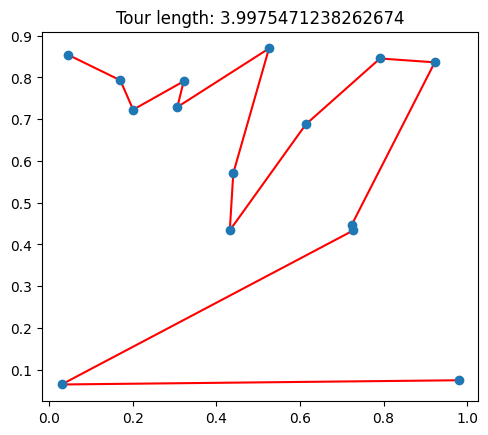

In [11]:
plot_solution(tsp.cities, solver.best_tour, solver.min_cost)

# Creating GIF

In [13]:
import imageio
import os
images = []
files = os.listdir('results/pheromones/')
files.sort()
for file in files:
    images.append(imageio.imread(os.path.join('results/pheromones/', file)))
imageio.mimsave('results/trails.gif', images, fps=5, loop=0)

/tmp/ipykernel_26623/1119161470.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join('results/pheromones/', file)))
